In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("ISAT.JK.csv")
data = data.dropna().reset_index()

In [ ]:
price = data[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#Create Sequence Data

In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [ ]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [ ]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
x_train.shape, x_test.shape

(torch.Size([3499, 19, 1]), torch.Size([875, 19, 1]))

In [ ]:
x_train

tensor([[[-0.4713],
         [-0.4023],
         [-0.4023],
         ...,
         [-0.2874],
         [-0.3103],
         [-0.3218]],

        [[-0.4023],
         [-0.4023],
         [-0.3966],
         ...,
         [-0.3103],
         [-0.3218],
         [-0.3333]],

        [[-0.4023],
         [-0.3966],
         [-0.4138],
         ...,
         [-0.3218],
         [-0.3333],
         [-0.3391]],

        ...,

        [[-0.2184],
         [-0.2184],
         [-0.4069],
         ...,
         [-0.5356],
         [-0.5425],
         [-0.5494]],

        [[-0.2184],
         [-0.4069],
         [-0.4069],
         ...,
         [-0.5425],
         [-0.5494],
         [-0.5448]],

        [[-0.4069],
         [-0.4069],
         [-0.4046],
         ...,
         [-0.5494],
         [-0.5448],
         [-0.5540]]])

In [ ]:
x_test

tensor([[[-0.4069],
         [-0.4046],
         [-0.4161],
         ...,
         [-0.5448],
         [-0.5540],
         [-0.5310]],

        [[-0.4046],
         [-0.4161],
         [-0.4253],
         ...,
         [-0.5540],
         [-0.5310],
         [-0.5149]],

        [[-0.4161],
         [-0.4253],
         [-0.4437],
         ...,
         [-0.5310],
         [-0.5149],
         [-0.5149]],

        ...,

        [[ 0.3276],
         [ 0.3161],
         [ 0.3218],
         ...,
         [ 0.3333],
         [ 0.3333],
         [ 0.2874]],

        [[ 0.3161],
         [ 0.3218],
         [ 0.3563],
         ...,
         [ 0.3333],
         [ 0.2874],
         [ 0.3103]],

        [[ 0.3218],
         [ 0.3563],
         [ 0.3161],
         ...,
         [ 0.2874],
         [ 0.3103],
         [ 0.2931]]])

#Build Model

In [ ]:
input_dim = 1
output_dim = 1

In [ ]:
class LSTM(nn.Module):
  
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
print(model)

LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean((np.abs(Y_Predicted-Y_actual)/Y_actual))*100
    return mape

#Hyperparameter Tuning

In [ ]:
list_hidden_dim = [1,8,16,32]
list_num_layers = [1,2]
list_lr = [0.01,0.05,0.1]
list_num_epochs = [50,100,200]

best_param = []
score = 100

for hidden_dim in list_hidden_dim:
  for num_layers in list_num_layers:
    for lr in list_lr:
      for num_epochs in list_num_epochs:
        model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
        criterion = torch.nn.MSELoss(reduction='mean')
        optimiser = torch.optim.Adam(model.parameters(), lr=lr)
        hist = np.zeros(num_epochs)
        lstm = []
        for t in range(num_epochs):
            y_train_pred = model(x_train)
            loss = criterion(y_train_pred, y_train)
            hist[t] = loss.item()
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            trainScore = loss.item()
        print("Hidden Layer:{}, LSTM: {}, Epochs: {}, Learning Rate: {}, MSE: {}".format(hidden_dim, num_layers, num_epochs, lr, trainScore))
        if (trainScore < score):
          score = trainScore
          best_param = [hidden_dim, num_layers, num_epochs, lr, score]

Hidden Layer:1, LSTM: 1, Epochs: 50, Learning Rate: 0.01, MSE: 0.010396159254014492
Hidden Layer:1, LSTM: 1, Epochs: 100, Learning Rate: 0.01, MSE: 0.004603882785886526
Hidden Layer:1, LSTM: 1, Epochs: 200, Learning Rate: 0.01, MSE: 0.0016253495123237371
Hidden Layer:1, LSTM: 1, Epochs: 50, Learning Rate: 0.05, MSE: 0.05139768868684769
Hidden Layer:1, LSTM: 1, Epochs: 100, Learning Rate: 0.05, MSE: 0.0010718496050685644
Hidden Layer:1, LSTM: 1, Epochs: 200, Learning Rate: 0.05, MSE: 0.0016126371920108795
Hidden Layer:1, LSTM: 1, Epochs: 50, Learning Rate: 0.1, MSE: 0.003436450148001313
Hidden Layer:1, LSTM: 1, Epochs: 100, Learning Rate: 0.1, MSE: 0.007423940114676952
Hidden Layer:1, LSTM: 1, Epochs: 200, Learning Rate: 0.1, MSE: 0.0017574370140209794
Hidden Layer:1, LSTM: 2, Epochs: 50, Learning Rate: 0.01, MSE: 0.054444730281829834
Hidden Layer:1, LSTM: 2, Epochs: 100, Learning Rate: 0.01, MSE: 0.05672943964600563
Hidden Layer:1, LSTM: 2, Epochs: 200, Learning Rate: 0.01, MSE: 0.0033

In [ ]:
hidden_dim = best_param[0]
num_layers = best_param[1]
num_epochs = best_param[2]
lr = best_param[3]

In [ ]:
best_param

[16, 2, 200, 0.05, 0.000885280198417604]

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

#Train Model Using Best Parameter

In [ ]:
import time
num_epochs = 200
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.09315897524356842
Epoch  1 MSE:  0.10037609934806824
Epoch  2 MSE:  0.057415250688791275
Epoch  3 MSE:  0.06362050026655197
Epoch  4 MSE:  0.06254980713129044
Epoch  5 MSE:  0.05901668220758438
Epoch  6 MSE:  0.056479476392269135
Epoch  7 MSE:  0.055565010756254196
Epoch  8 MSE:  0.05548524856567383
Epoch  9 MSE:  0.05467734858393669
Epoch  10 MSE:  0.05194647237658501
Epoch  11 MSE:  0.0465097613632679
Epoch  12 MSE:  0.03687793388962746
Epoch  13 MSE:  0.021591082215309143
Epoch  14 MSE:  0.014867221005260944
Epoch  15 MSE:  0.04891182854771614
Epoch  16 MSE:  0.011231640353798866
Epoch  17 MSE:  0.01553053967654705
Epoch  18 MSE:  0.01925990916788578
Epoch  19 MSE:  0.019338954240083694
Epoch  20 MSE:  0.016155293211340904
Epoch  21 MSE:  0.011231531389057636
Epoch  22 MSE:  0.009034393355250359
Epoch  23 MSE:  0.010567822493612766
Epoch  24 MSE:  0.008738076314330101
Epoch  25 MSE:  0.008825315162539482
Epoch  26 MSE:  0.006512692663818598
Epoch  27 MSE:  0.0033307

#Predict Test Data

In [ ]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate MAPE
trainScore = mean_squared_error(y_train[:,0], y_train_pred[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test, y_test_pred)
print('Test Score: %.2f MSE' % (testScore))

Train Score: 16909.71 MSE
Test Score: 116316.88 MSE


#Plotting Test Result

In [ ]:
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)
result = result[-875:]

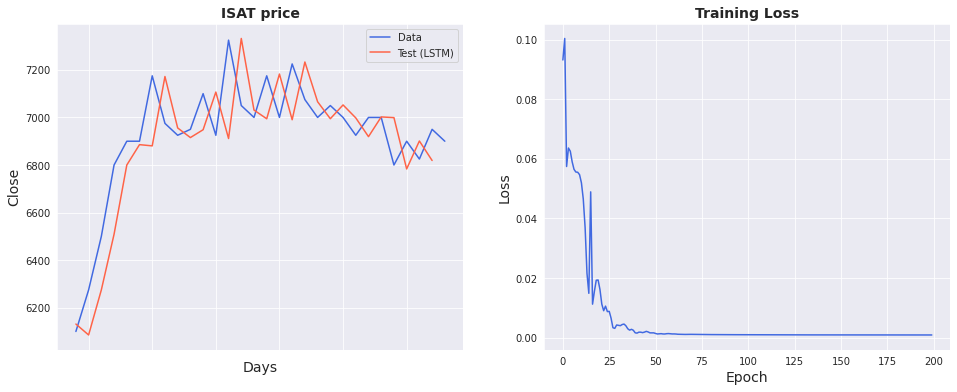

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = result[-30:].index, y = result[2][-30:], label="Data", color='royalblue')
ax = sns.lineplot(x = result[-30:].index, y = result[1][-30:], label="Test (LSTM)", color='tomato')
ax.set_title('ISAT price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Close", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
MAPE(result[2][-30:],result[1][-30:])

2.020999992683453